# House Prices in Argentina
## Project Code and Descriptions
### JonPaul Ferzacca & Joey Musholt

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data Sets - ar_properties.csv & ars-usd.csv

In [2]:
# Load the datasets
data = pd.read_csv('/Users/jp_ferzacca/Data_Mining/ar_properties.csv')
ars_usd = pd.read_csv('/Users/jp_ferzacca/Data_Mining/CSCI-4502_Data_Mining_Project/ars-usd.csv')


### Data Exploration

In [3]:
# Initial Data Exploration
print(data.columns)
print(data.head())

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')
                         id    ad_type  start_date    end_date  created_on  \
0  wdQ5hWhv8P14T7Sh9g4QCg==  Propiedad  2020-12-25  9999-12-31  2020-12-25   
1  nnMBYZ4RMRY+vm753EtA+g==  Propiedad  2020-12-25  9999-12-31  2020-12-25   
2  +dnVA1K6JxzL1zAjOEQ1pA==  Propiedad  2020-12-25  2020-12-29  2020-12-25   
3  dLHXKN5/sRZpm9Yk0yI2nA==  Propiedad  2020-12-25  2020-12-29  2020-12-25   
4  wtw/k887EPipd37UYHKb1Q==  Propiedad  2020-12-25  9999-12-31  2020-12-25   

         lat        lon         l1                        l2        l3  ...  \
0 -32.716652 -68.642692  Argentina                   Mendoza       NaN  ...   
1 -24.797723 -65.467514  Argentina               

In [4]:
# Calculate the number of missing values in each column
missing_values = data.isna().sum()
# Print the number of missing values for each column
print(missing_values)

id                       0
ad_type                  0
start_date               0
end_date                 0
created_on               0
lat                 150811
lon                 151745
l1                       0
l2                       0
l3                   53327
l4                  760504
l5                  994999
l6                 1000000
rooms               473577
bedrooms            533787
bathrooms           223267
surface_total       620499
surface_covered     618549
price                36902
currency             38281
price_period        636985
title                    0
description             18
property_type            0
operation_type           0
dtype: int64


In [5]:
# Count rows missing both 'surface_total' and 'surface_covered'
missing_surface = data[data['surface_total'].isna() & data['surface_covered'].isna()]
num_missing_surface = len(missing_surface)
print(f"Number of rows missing both 'surface_total' and 'surface_covered': {num_missing_surface}")


Number of rows missing both 'surface_total' and 'surface_covered': 569991


In [6]:
# Count rows missing both 'rooms' and 'bedrooms'
missing_rooms = data[data['rooms'].isna() & data['bedrooms'].isna()]
num_missing_rooms = len(missing_rooms)
print(f"Number of rows missing both 'rooms' and 'bedrooms': {num_missing_rooms}")

# Count rows missing 'rooms', 'bedrooms', and 'bathrooms'
missing_rooms_bedrooms_bathrooms = data[data['rooms'].isna() & data['bedrooms'].isna() & data['bathrooms'].isna()]
num_missing_rooms_bedrooms_bathrooms = len(missing_rooms_bedrooms_bathrooms)

print(f"Number of rows missing 'rooms', 'bedrooms', and 'bathrooms': {num_missing_rooms_bedrooms_bathrooms}")

Number of rows missing both 'rooms' and 'bedrooms': 417303
Number of rows missing 'rooms', 'bedrooms', and 'bathrooms': 173330


### Data Cleaning and Preproccessing

In [7]:
# Remove rows where price is zero or NaN
original_length = len(data)
data = data[data['price'] > 0]
cleaned_length = len(data)
print(f"Original number of rows: {original_length}")
print(f"Number of rows after removing missing/zero prices: {cleaned_length}")


Original number of rows: 1000000
Number of rows after removing missing/zero prices: 961581


In [8]:
# Drop columns that are no longer needed or are identifiers
columns_to_drop = ['id', 'ad_type', 'l1', 'l4', 'l5', 'l6', 'title', 'description', 'currency', 'price_period']

# Check if each column in columns_to_drop exists in the DataFrame before dropping
columns_to_drop = [col for col in columns_to_drop if col in data.columns]

# Drop the columns
data = data.drop(columns=columns_to_drop, axis=1)

# Display the remaining columns to verify
print(data.columns)

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'property_type', 'operation_type'],
      dtype='object')


In [9]:
# Remove rows where 'rooms', 'bedrooms', and 'bathrooms' are all missing
data_cleaned = data.dropna(subset=['rooms', 'bedrooms', 'bathrooms'], how='all')

In [10]:
# Display the shape of the new DataFrame to verify the rows were removed
print(f"Original number of rows: {len(data)}")
print(f"Number of rows after removal: {len(data_cleaned)}")

Original number of rows: 961581
Number of rows after removal: 798510


In [11]:
# Function to filter valid dates
def filter_valid_dates(data, column):
    print(f"Processing column: {column}")
    if column not in data.columns:
        print(f"Column {column} not found in DataFrame.")
        return data
    data[column] = pd.to_datetime(data[column], errors='coerce')
    return data.dropna(subset=[column])

# Apply the function to date columns
data = filter_valid_dates(data, 'start_date')
data = filter_valid_dates(data, 'end_date')
data = filter_valid_dates(data, 'created_on')

Processing column: start_date
Processing column: end_date
Processing column: created_on


In [12]:
# Convert latitude and longitude to float
data.lat = data.lat.astype(float)
data.lon = data.lon.astype(float)

In [13]:
# Function to reformat date strings to datetime objects
def reformat_dates(date_array):
    dates_dict = {}
    formatted_date = []
    for date in date_array:
        if date not in dates_dict:
            try:
                # Try converting the date, and use a placeholder if it fails
                dates_dict[date] = pd.to_datetime(date)
            except (pd._libs.tslibs.np_datetime.OutOfBoundsDatetime, OverflowError):
                # Use a placeholder date such as '3/15/2021' or set to NaN
                dates_dict[date] = pd.to_datetime('3/15/2021')  # or pd.NaT for missing time
        formatted_date.append(dates_dict[date])
    return formatted_date

# Apply the function to date columns
data.start_date = reformat_dates(data.start_date)
data.end_date = reformat_dates(data.end_date)
data.created_on = reformat_dates(data.created_on)
ars_usd.date = reformat_dates(ars_usd.date)

In [14]:
# Convert numeric columns from strings to floats
numeric_features = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
data[numeric_features] = data[numeric_features].astype(float)

### Feature Engineering

In [15]:
# Log Transformations

# Fill NaN values in numeric features and ensure no negative values
for feature in numeric_features:
    data[feature] = data[feature].fillna(0).clip(lower=0)

# Apply log transformation
def apply_log_transform(data, features):
    for feature in features:
        data['log_' + feature] = np.log1p(data[feature])  # log1p is used to handle zero values
    return data

data = apply_log_transform(data, numeric_features)


In [16]:
# Create date-related features
data['listing_duration'] = (data['end_date'] - data['start_date']).dt.days  # Duration in days
data['listing_age'] = (pd.Timestamp('today') - data['created_on']).dt.days  # Age in days from today

In [17]:
# One-hot encoding of categorical variables
categorical_features = ['property_type', 'operation_type']
data = pd.get_dummies(data, columns=categorical_features)

additional_categorical_features = ['l2', 'l3', ...]  # Add other categorical columns here
for feature in additional_categorical_features:
    if feature in data.columns:
        data = pd.get_dummies(data, columns=[feature])

In [18]:
# Calculate distance to a central point in Buenos Aires
def calculate_distance(lat1, lon1, lat2, lon2):
    if pd.isna(lat1) or pd.isna(lon1):
        return np.nan  # or return some default value
    return great_circle((lat1, lon1), (lat2, lon2)).kilometers

central_point = (-34.6037, -58.3816)  # Coordinates of Buenos Aires central
data['distance_to_central'] = data.apply(lambda row: calculate_distance(row['lat'], row['lon'], central_point[0], central_point[1]), axis=1)

### Model Building

In [19]:
# Convert datetime columns to numeric
reference_date = pd.Timestamp('2023-01-01')  # Choose an appropriate reference date
data['days_since_start'] = (data['start_date'] - reference_date).dt.days
data['days_since_end'] = (data['end_date'] - reference_date).dt.days
data['days_since_created'] = (data['created_on'] - reference_date).dt.days

# Drop the original datetime columns
data = data.drop(['start_date', 'end_date', 'created_on'], axis=1)

In [20]:
# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Remove 'price' and 'log_price' from numeric_cols if present
numeric_cols = [col for col in numeric_cols if col not in ['price', 'log_price']]

# Splitting the dataset into training and testing sets
X = data.drop(['price', 'log_price'], axis=1)  # Drop target variable and non-feature columns
y = data['log_price']  # Assuming log_price is the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Imputation of missing values for numeric data
imputer_numeric = SimpleImputer(strategy='median')
X_train_numeric = imputer_numeric.fit_transform(X_train[numeric_cols])
X_test_numeric = imputer_numeric.transform(X_test[numeric_cols])

# Convert boolean columns to integers
for col in X_train.columns:
    if X_train[col].dtype == 'bool':
        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)
        
# For categorical data, you can use a different strategy, like 'most_frequent' or 'constant'
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_train_categorical = imputer_categorical.fit_transform(X_train[categorical_cols])
X_test_categorical = imputer_categorical.transform(X_test[categorical_cols])

# Combine numeric and categorical data back into one DataFrame
X_train_imputed = np.concatenate((X_train_numeric, X_train_categorical), axis=1)
X_test_imputed = np.concatenate((X_test_numeric, X_test_categorical), axis=1)

# Fitting the Linear Regression Model
model = LinearRegression()
model.fit(X_train_imputed, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_imputed)


### Model Evaluation

In [22]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.676857385374826
Mean Squared Error (MSE): 1.0080877763481029
R-squared (R²): 0.5062553440335252


#### Residuals Plot

Purpose: This plot highlights the differences (residuals) between the actual and predicted values. A well-fitted model should have residuals randomly scattered around zero.
Description: Points in the plot represent individual predictions. The X-axis shows the actual log prices, and the Y-axis represents the residuals. A horizontal line at zero acts as a reference to identify over and underestimations by the model.

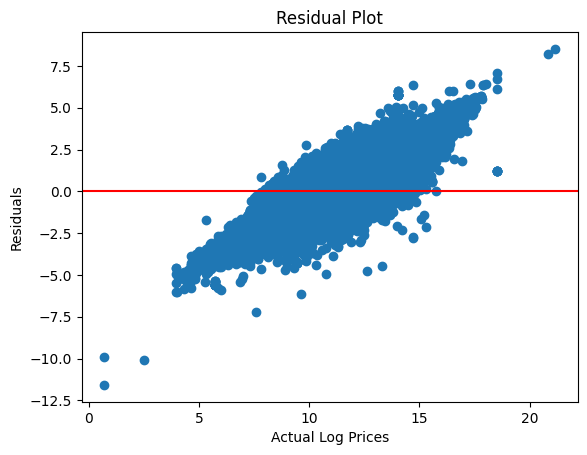

In [23]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Log Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.show()

#### Prediction vs Actual Scatter Plot

Purpose: To assess the accuracy of the model's predictions in comparison to the actual values.
Description: Each point represents a property, with its actual log price on the X-axis and the predicted log price on the Y-axis. A diagonal line (45-degree) is drawn to represent a perfect prediction. The closer the points to this line, the more accurate the predictions. Deviations from this line indicate prediction errors.

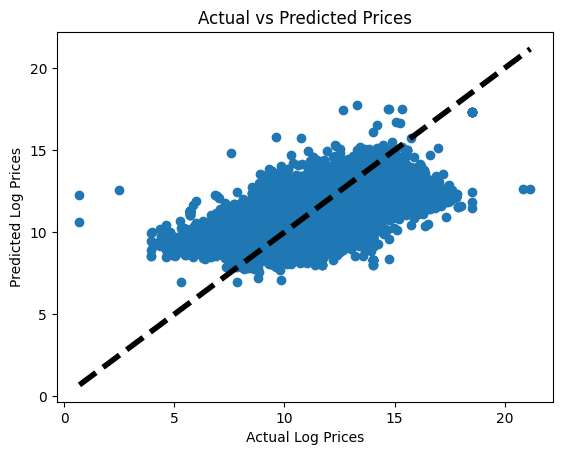

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Log Prices')
plt.ylabel('Predicted Log Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

#### Error Distribution Plot

Purpose: To examine the distribution of prediction errors (residuals), checking for normality and identifying any biases in the model.
Description: This histogram shows the frequency of different residual values, with a kernel density estimate (KDE) overlay providing a smooth distribution curve. The X-axis shows the residuals, while the Y-axis shows their frequency. An ideal plot should resemble a normal distribution centered around zero, indicating random errors.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


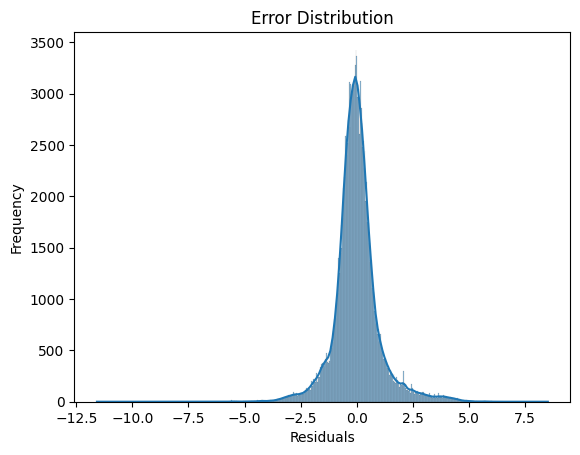

In [25]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()